# Try the torchhub models
Requires tensorflow and pytorch. 

In [1]:
# imports
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import torch
import timm
import random

from fastai.vision.core import DataLoaders
from fastai.vision.core import DataLoader

from fastai import *
from fastai.vision.all import *

from opensoundscape.ml.cnn import load_model
from opensoundscape import Audio
import opensoundscape

import torch
from pathlib import Path
import numpy as np
from glob import glob
import subprocess
import tensorflow as tf

/Users/mikeg/miniforge3/envs/osfltens/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# load the raw dataframe


In [2]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.com/d7ede4f0-7336-462b-9e64-43068e1fbd86/9f686a1bc16b4bbaaa8db056d2553c4c.jpg,https://wildtrax-aru.s3.us-west-2.amazonaws.com/d7ede4f0-7336-462b-9e64-43068e1fbd86/9f686a1bc16b4bbaaa8db056d2553c4c.mp3,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.com/d7ede4f0-7336-462b-9e64-43068e1fbd86/92051.flac,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.com/d7ede4f0-7336-462b-9e64-43068e1fbd86/38429b4f152045b1b5799f37a1a4ecc0.jpg,https://wildtrax-aru.s3.us-west-2.amazonaws.com/d7ede4f0-7336-462b-9e64-43068e1fbd86/38429b4f152045b1b5799f37a1a4ecc0.mp3,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.com/d7ede4f0-7336-462b-9e64-43068e1fbd86/92051.flac,54.607774,-110.681271,NaN,flac


### Take a sample of the recordings
Training loop is slow with all the data - use a sample to speed things up if necessary. 
Samples taken at the recording level

In [3]:
def take_sample(df, sample_fraction=0.1):
    unique_recordings = list(set(df.recording_id))
    sample_size = round(sample_fraction * len(unique_recordings))
    sample_recordings = random.sample(unique_recordings, sample_size)
    df_sample = df[df.recording_id.isin(sample_recordings)]
    print(f"sampled {len(sample_recordings)} recordings from the original {len(unique_recordings)} ")
    return df_sample

df_train_sample = take_sample(df_train, sample_fraction=0.1)


sampled 5442 recordings from the original 54416 


# Turn dataframe into an AudioFileDataset 


4 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    20973
None     5908
1SPM     5469
Name: count, dtype: int64
total recordings = 32350

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                   192.0           957.0
1SPT                   267.0          2963.0
NaN                     61.0           422.0
total target clips =  520
total absence clips =  4342
total available human labelled target tags = 405
undefined 27488

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    3230
1SPM    1149
None     483
Name: count, dtype: int64
total recordings = 4862

Tags generated from each tagging method:
             target_presence  target_absence
task_method    

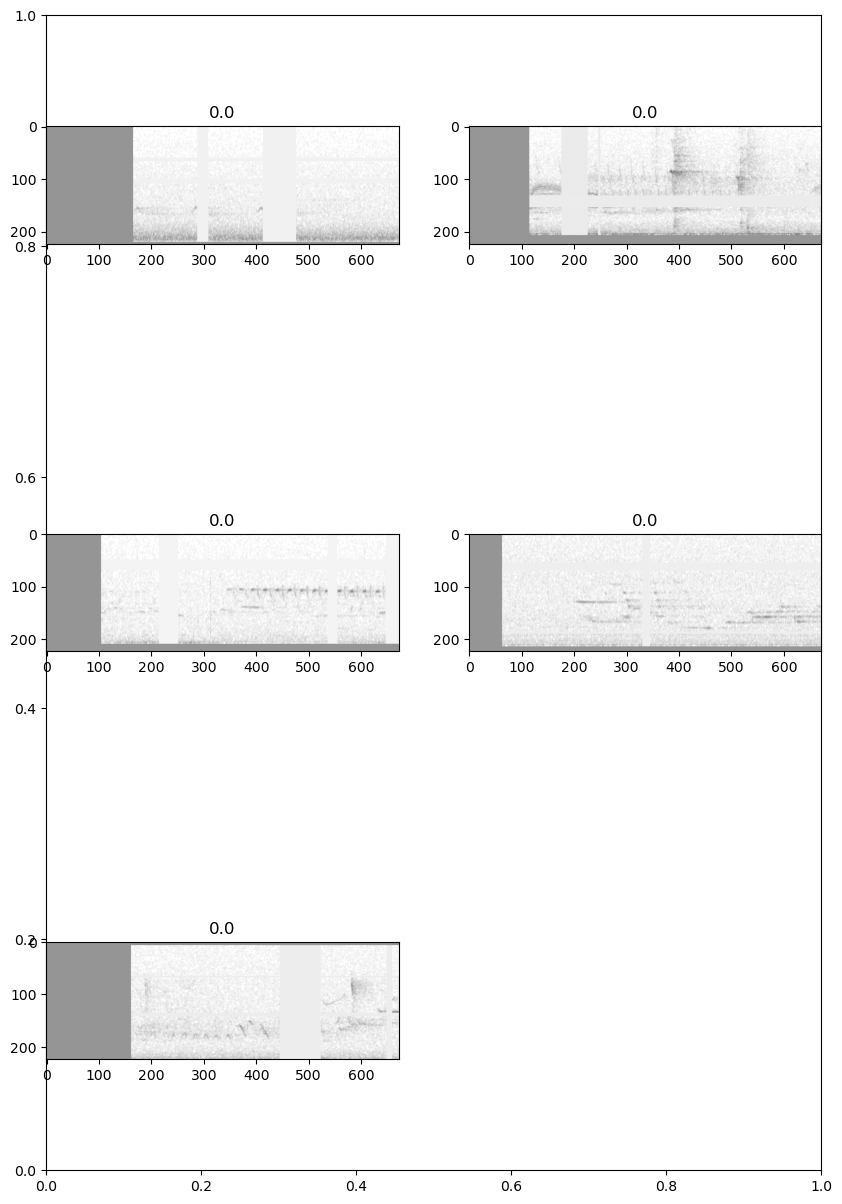

In [4]:
target_species = "OSFL"
train_dataset, valid_dataset, train_locations, valid_locations = src.data.build.dataset_from_df(df_train_sample, target_species=target_species, download_n=0, one_class=False)

### Downsample the absent class

In [5]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([415., 415.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([105., 105.])))

In [6]:
# optionally remove the redundant second label
def drop_absent_class(ds: opso.AudioFileDataset):
    ds.label_df.drop(columns='target_absence', inplace=True)
# drop_absent_class(train_dataset)
# drop_absent_class(valid_dataset)

### Check that the Dataset looks right

In [7]:
print("training set class counts")
print(train_dataset.label_df.target_presence.value_counts())
print(train_dataset.label_df.target_absence.value_counts())
print("\nvalidation set class counts")
print(valid_dataset.label_df.target_presence.value_counts())
print(valid_dataset.label_df.target_absence.value_counts())

training set class counts
target_presence
1.0    415
0.0    415
Name: count, dtype: int64
target_absence
0.0    415
1.0    415
Name: count, dtype: int64

validation set class counts
target_presence
1.0    105
0.0    105
Name: count, dtype: int64
target_absence
0.0    105
1.0    105
Name: count, dtype: int64


In [8]:
l = len(train_dataset)
[train_dataset[i].labels for i in [1, 2, l-1, l-2]]

[target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4607.mp3, 90.0, 93.0), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4915.flac, 10.5, 13.5), dtype: float64,
 target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-282687.mp3, 75.0, 78.0), dtype: float64,
 target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-555599.flac, 16.5, 19.5), dtype: float64]

There are equal numbers of classes, and there are 2 classes per dataset. After the OpenSoundScape resample method, the dataset ends up sorted by class, so we need to make sure to shuffle it again when loading batches of training data. 

# Look at typical spectrograms from the dataset

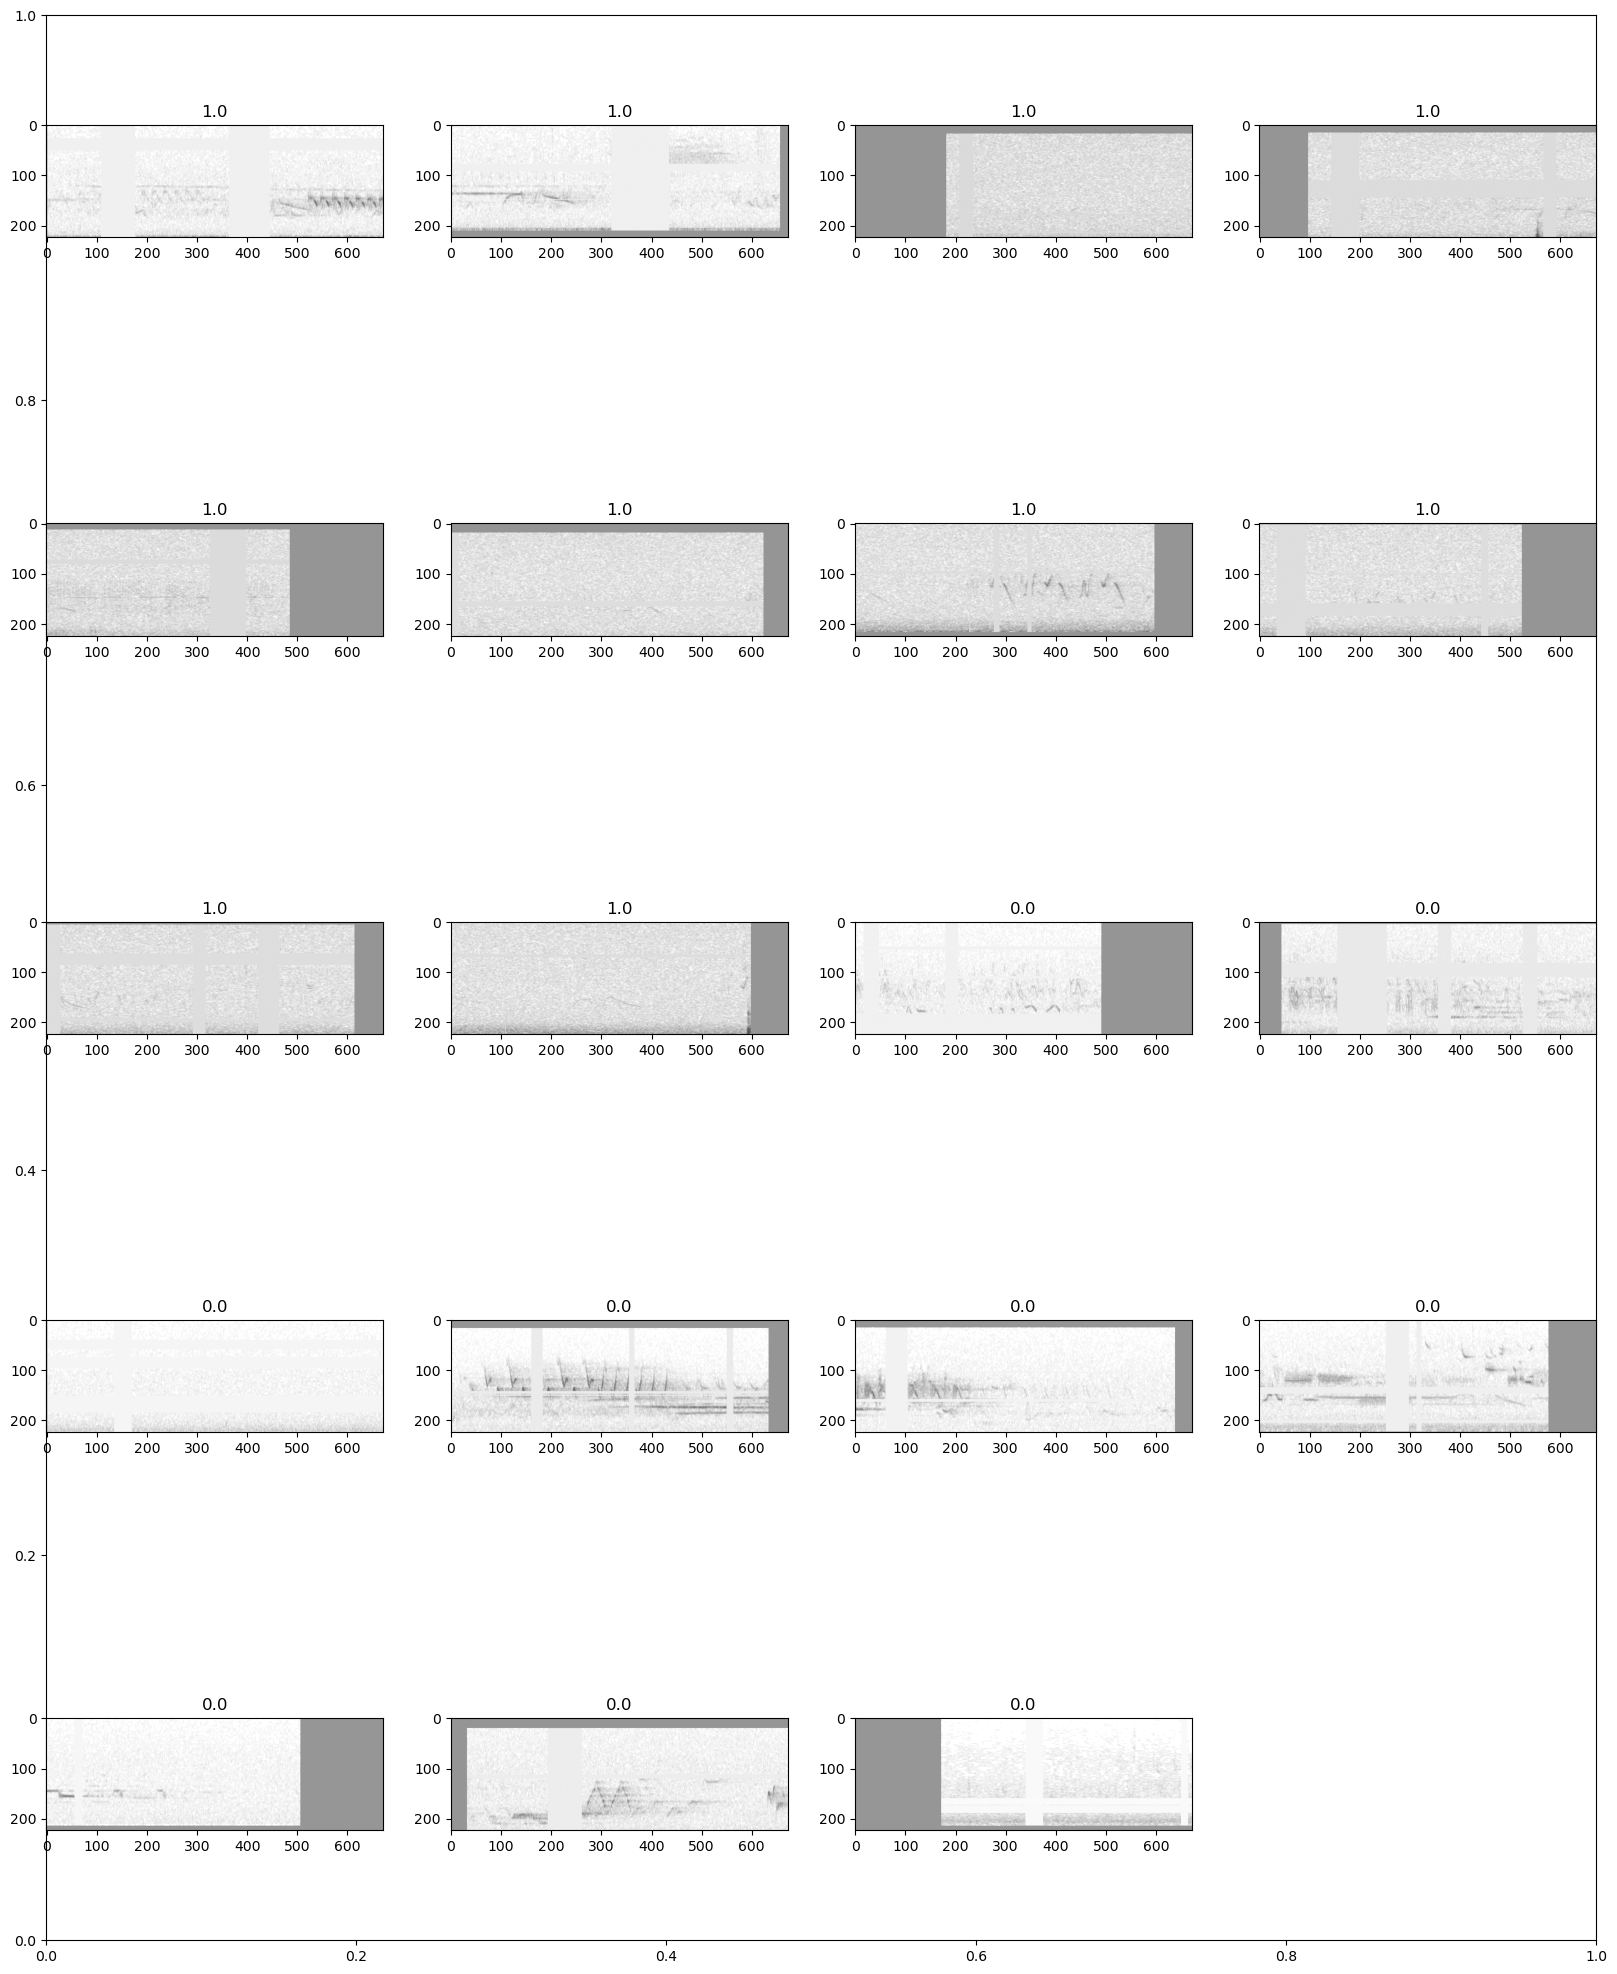

In [9]:
idxs=[i for i in range(10)]+[i for i in range(-9, 0, 1)]
fig = show_tensor_grid([train_dataset[i].data for i in idxs], columns = 4, labels = [train_dataset[i].labels.iloc[0] for i in idxs])

In [29]:
class AudioDatasetWrapper(Datasets):
    '''
    Alternative behaviour to the __getitem__ method of AudioFileDataset.
    Converts greyscale images to RGB
    Returns a tuple of the data and the label.
    '''
    def __init__(self, audio_dataset, greyscale_to_rgb=False):
        self.audio_dataset = audio_dataset
        self.greyscale_to_rgb = greyscale_to_rgb

    def __len__(self):
        return len(self.audio_dataset)

    def __getitem__(self, idx):
        # Extract the data tensor
        # Extract the label as an integer in a tensor
        x = self.audio_dataset[idx].data
        y = torch.tensor(int(self.audio_dataset[idx].labels.iloc[0]))

        if self.greyscale_to_rgb:
            x = x.repeat(3, 1, 1)
        
        return (x, y)

def wrap(dataset):
    return AudioDatasetWrapper(dataset)


In [30]:
# Check channel conversion
print(AudioDatasetWrapper(train_dataset, greyscale_to_rgb=False)[0][0].shape)
print(AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True )[0][0].shape)

torch.Size([1, 224, 672])
torch.Size([3, 224, 672])


In [31]:
# make dataloaders
wrapped_train_ds = AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True)
wrapped_valid_ds = AudioDatasetWrapper(valid_dataset, greyscale_to_rgb=True)
train_dl = DataLoader(wrapped_train_ds,shuffle=True, bs=16)
valid_dl = DataLoader(wrapped_valid_ds, bs=16)
dls = DataLoaders(train_dl, valid_dl, device="mps")
dls.one_batch()[1].shape # label shape

torch.Size([16])

The wrapper only extracts the presence class from the dataset, since at this stage the absence class is redundant. So the presence/absence is encoded as 1 or 0, and isn't one-hot encoded. 

In [32]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([415., 415.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([105., 105.])))

# Out of the box
 the resnet 18 model has 1000 output classes. This is the original number of output classes of the ImageNet dataset it was trained on. We need to explicilty remove the last layer and replace it with a layer with 2 output classes. The activations at index 0 and 1 are all positive, and the rest are small. The head needs replacing with a new head with 2 classes.

# Model 1 - custom wrapper

# Replace with 2 class head

In [33]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2, device='mps') # replace the head
learner = Learner(dls, model, metrics=accuracy, loss_func=nn.CrossEntropyLoss())
learner.fine_tune(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

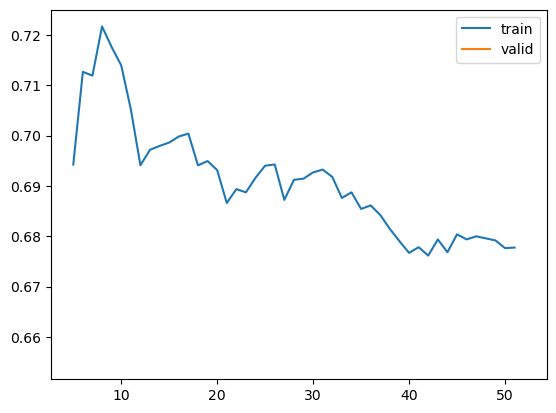

In [ ]:
learner.recorder.plot_loss()

# Try a biocacoustics model from the pytorch hub

In [34]:
torch.hub.list('kitzeslab/bioacoustics-model-zoo')

Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['BirdNET', 'Perch', 'SeparationModel', 'YAMNet', 'rana_sierrae_cnn']

In [35]:
tf.__version__

'2.15.0'

In [36]:
x,y = dls.one_batch()

In [37]:

torch.hub.list('kitzeslab/bioacoustics-model-zoo')
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn')


Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main
Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [38]:
x = [train_dataset[n] for n in range(10)]


In [39]:

model=torch.hub.load('kitzeslab/bioacoustics-model-zoo', 'BirdNET')
type(model)


Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


downloading model from URL...
Downloaded completed: BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite
Downloaded completed: BirdNET_GLOBAL_6K_V2.4_Labels_af.txt


bioacoustics_model_zoo.birdnet.BirdNET

In [40]:
learner = Learner(dls, model, metrics=accuracy, loss_func=nn.CrossEntropyLoss())
learner.fine_tune(1, 1e-4)

AttributeError: 'BirdNET' object has no attribute '_parameters'

In [ ]:
x,y = dls.one_batch()
preds = learner.model(x)
preds.shape

torch.Size([16, 2])

#  Try using the opensoundscape custom collate function

This might be quicker due to the use of tensor operations rather than python loops.

`collate_audio_samples_to_tensors` takes a list of AudioSamples and batches them into tensors. This is the behaviour we need to be able to pass the dataset to a fastai learner.

In [ ]:
collate_test = opso.ml.utils.collate_audio_samples_to_tensors([train_dataset[i] for i in range(5)])

collate_test[0].shape, collate_test[1].shape

(torch.Size([5, 1, 224, 672]), torch.Size([5, 2]))

In [ ]:
collate_test[1]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

#### Difference in target dimension

The leading dimension is the batch dimension. The 2 dimensional target highlights that the data is structured with two target classes: 'present' and 'absent'. Since we're currently only using these two classes, the data could be represented with only one of these classes since the presence of one always indicates the absence of the other. 


### Multi class
providing multiple labels for the classifier to differentiate between could help with performance - a class for 'other bird' 'target bird', 'background' are all derivable from this dataset. 

#### Loss function
The loss function needs to be designed to have smooth gradients as the parameters are changed. Accuracy as measured by the number of correct IDs is suitable for use as a human readable metric, but can't serve as a loss function due to the sudden jumps in integer numbers of correct ids. 

The loss function needs to show that a prediction was slightly better or worse for a small change in parameters. In addition it may need to have a weighting to account for the upsampling or undersampling of classes within the training dataset. 


Different loss functions also require different shaped targets, some need the scores from each target to sum to 1 (Cross Entropy Loss), and some (Binary Cross Entropy) can work on one hot encoded targets and handle multiple positive labels per example. 

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    bs=16,
    shuffle=True,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)
valid_dataloader = DataLoader(
    valid_dataset,
    bs=16,
    shuffle=False,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)


In [ ]:
type(valid_dataloader.one_batch())

tuple

Passing `create_batch = opso.ml.utils.collate_audio_samples_to_tensors` into `DataLoader` gives the expected behaviour of returning a tuple containing tensor spectrograms and their labels.

In [ ]:
dls = DataLoaders(train_dataloader,valid_dataloader, device="mps")

### Check shape of input labels

In [41]:
x, y = dls.one_batch()
x.shape, y.shape
x.device, y.device, x.dtype, y.dtype

(device(type='mps', index=0),
 device(type='mps', index=0),
 torch.float32,
 torch.int64)

In [43]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat())

In [44]:
learn.fine_tune(4, 1e-4)

AttributeError: 'BirdNET' object has no attribute '_parameters'

The implementation of a tensorflow based model as a PyTorch model would take a lot of work, and at that stage would be better done in tensorflow.